In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset,DataLoader

In [2]:
df = pd.read_csv(r"C:\Users\admin\Desktop\week_of_data4_headFlaw.csv",encoding='utf-8',header=None)
df.head(10)

,0,1,2,3
0,2015/5/20 0:00,263,240,2015/5/20
1,2015/5/20 0:05,263,234,2015/5/20
2,2015/5/20 0:10,263,228,2015/5/20
3,2015/5/20 0:15,263,227,2015/5/20
4,2015/5/20 0:20,263,228,2015/5/20
5,2015/5/20 0:25,263,226,2015/5/20
6,2015/5/20 0:30,263,224,2015/5/20
7,2015/5/20 0:35,263,219,2015/5/20
8,2015/5/20 0:40,263,213,2015/5/20
9,2015/5/20 0:45,263,205,2015/5/20


In [3]:
df.columns = ['time','id','gl', 'date']
df = df[['time','id','gl']]
df.head()

,time,id,gl
0,2015/5/20 0:00,263,240
1,2015/5/20 0:05,263,234
2,2015/5/20 0:10,263,228
3,2015/5/20 0:15,263,227
4,2015/5/20 0:20,263,228


In [4]:
ID = df['id'].value_counts().index
pd.set_option('display.max_rows',100)
print(ID)
print(len(ID))

Index([263, 106, 185, 218,  74,  53, 216, 219, 113,  47,  14, 134,  37,  61,
        46,  33,  54, 278, 136, 274,   9, 265, 283, 273, 119, 129,  32,  27,
       236,  26, 206,  18, 165,  31,  24, 267,  22, 247, 124,  79, 258,  58,
       234, 175, 156, 158, 188, 189, 201, 203,  77, 127,  67,  70, 102, 137,
         7,  95, 232,  23, 271, 130,  68, 227, 228, 164, 111, 251, 155, 245,
       229, 277, 193, 101, 269,   3, 250, 116, 109,  81,  65, 184, 146, 105,
       138,  76, 198, 139, 214, 166, 135, 123, 253, 187,  17, 205, 220, 243,
       281],
      dtype='int64', name='id')
99


In [5]:
#获取数据

# 创建空的DataFrame
total_data = {'id': [],'month':[],'day':[],'hour':[],'minute':[],'weekday':[],'gl': []}
total_data = pd.DataFrame(total_data)

for i in ID:
    print("开始获取id为{}的被试数据：---------------------------------".format(i))
    data = df[df['id']== i].copy() 
    print(data.shape)
    #将time列设成date数据类型
    data['time'] = pd.to_datetime(data['time'])

    #按照时间排序
    data = data.sort_values(by='time') 

    #提取月为单独的一列
    data['month'] = data['time'].dt.month

    #提取日为单独的一列
    data['day'] = data['time'].dt.day

    #提取小时为单独的一列
    data['hour'] = data['time'].dt.hour

    #提取分钟为单独的一列
    data['minute'] = data['time'].dt.minute

    # 提取周几（0表示星期一，1表示星期二，依此类推）
    data['weekday'] = data['time'].dt.dayofweek

    data = data.set_index('time')

#     data['target'] = data['gl'].shift(-1)

    #使用了shift函数，在最后必然是有缺失值的，这里去掉缺失值所在行
    data = data.dropna()     

    data = data.astype(np.float32) # 修改数据类型
    
    #整合全部数据
    total_data = pd.concat([total_data, data], ignore_index=True)

开始获取id为263的被试数据：---------------------------------
(2016, 3)
开始获取id为106的被试数据：---------------------------------
(2016, 3)
开始获取id为185的被试数据：---------------------------------
(2016, 3)
开始获取id为218的被试数据：---------------------------------
(2016, 3)
开始获取id为74的被试数据：---------------------------------
(2016, 3)
开始获取id为53的被试数据：---------------------------------
(2016, 3)
开始获取id为216的被试数据：---------------------------------
(2016, 3)
开始获取id为219的被试数据：---------------------------------
(2016, 3)
开始获取id为113的被试数据：---------------------------------
(2016, 3)
开始获取id为47的被试数据：---------------------------------
(2016, 3)
开始获取id为14的被试数据：---------------------------------
(2016, 3)
开始获取id为134的被试数据：---------------------------------
(2016, 3)
开始获取id为37的被试数据：---------------------------------
(2016, 3)
开始获取id为61的被试数据：---------------------------------
(2016, 3)
开始获取id为46的被试数据：---------------------------------
(2016, 3)
开始获取id为33的被试数据：---------------------------------
(2016, 3)
开始获取id为54的被试数据：---------------------------------

In [8]:
#窗口划分
# 创建一个空的三维数组

train_total_feats = np.empty((0, 24, 7))
train_total_targets = np.empty((0,7))

test_total_feats = np.empty((0, 398, 24, 7))
test_total_targets = np.empty((0, 398, 7))

# 设每条数据序列有24组数据
seq = 24
for i in ID:
    data = total_data[total_data['id'] == i]
    print("当前被试(id == {})的数据集长度：".format(i),data.shape)
    
    # 创建两个列表，用来存储当前被试的数据特征和标签
    one_feats = np.empty((0, 24, 7))
    one_targets = np.empty((0,7))
    for index in range(len(data) - seq):
        # 构建特征集
        one_feats = np.concatenate((one_feats, data[index: index + seq].values.reshape(-1,24,7)), axis=0)
        # 构建target集
        one_targets = np.concatenate((one_targets, data.iloc[index + seq].values.reshape(1,-1)), axis=0)
    
    #划分每个被试的训练集和测试集
    test_size = int(np.round(0.2 * one_feats.shape[0]))  # np.round(1)是四舍五入，
    train_size = one_feats.shape[0] - test_size 
    
    train_total_feats = np.concatenate((train_total_feats, one_feats[:train_size, :, :]), axis=0)
    train_total_targets = np.concatenate((train_total_targets, one_targets[:train_size,:]), axis=0)
    
    test_total_feats= np.concatenate((test_total_feats, one_feats[train_size:, :, :].reshape(1,-1,24,7)), axis=0)
    test_total_targets = np.concatenate((test_total_targets, one_targets[train_size:,:].reshape(1,-1,7)), axis=0)

当前被试(id == 263)的数据集长度： (2016, 7)
当前被试(id == 106)的数据集长度： (2016, 7)
当前被试(id == 185)的数据集长度： (2016, 7)
当前被试(id == 218)的数据集长度： (2016, 7)
当前被试(id == 74)的数据集长度： (2016, 7)
当前被试(id == 53)的数据集长度： (2016, 7)
当前被试(id == 216)的数据集长度： (2016, 7)
当前被试(id == 219)的数据集长度： (2016, 7)
当前被试(id == 113)的数据集长度： (2016, 7)
当前被试(id == 47)的数据集长度： (2016, 7)
当前被试(id == 14)的数据集长度： (2016, 7)
当前被试(id == 134)的数据集长度： (2016, 7)
当前被试(id == 37)的数据集长度： (2016, 7)
当前被试(id == 61)的数据集长度： (2016, 7)
当前被试(id == 46)的数据集长度： (2016, 7)
当前被试(id == 33)的数据集长度： (2016, 7)
当前被试(id == 54)的数据集长度： (2016, 7)
当前被试(id == 278)的数据集长度： (2016, 7)
当前被试(id == 136)的数据集长度： (2016, 7)
当前被试(id == 274)的数据集长度： (2016, 7)
当前被试(id == 9)的数据集长度： (2016, 7)
当前被试(id == 265)的数据集长度： (2016, 7)
当前被试(id == 283)的数据集长度： (2016, 7)
当前被试(id == 273)的数据集长度： (2016, 7)
当前被试(id == 119)的数据集长度： (2016, 7)
当前被试(id == 129)的数据集长度： (2016, 7)
当前被试(id == 32)的数据集长度： (2016, 7)
当前被试(id == 27)的数据集长度： (2016, 7)
当前被试(id == 236)的数据集长度： (2016, 7)
当前被试(id == 26)的数据集长度： (2016, 7)
当前被试(id == 206)的数据集长度： (

In [ ]:
# 将变量保存到文件，以便下次直接读取，不用在处理数据
np.save('./variable_file/train_total_feats.npy',train_total_feats)
np.save('./variable_file/train_total_targets.npy',train_total_targets)
np.save('./variable_file/test_total_feats.npy',test_total_feats)
np.save('./variable_file/test_total_targets.npy',test_total_targets)

In [4]:
# 加载变量的代码：
# train_total_feats = np.load('./variable_file/train_total_feats.npy')
train_total_feats = np.load('./variable_file/train_total_feats.npy')
train_total_targets = np.load('./variable_file/train_total_targets.npy')
test_total_feats = np.load('./variable_file/test_total_feats.npy')
test_total_targets = np.load('./variable_file/test_total_targets.npy')

print("训练数据窗口总数：",train_total_feats.shape)
print("训练数据标签总数：",train_total_targets.shape)
print("测试数据窗口数：",test_total_feats.shape)
print("测试数据标签数：",test_total_targets.shape)

训练数据窗口总数： (157806, 24, 7)
训练数据标签总数： (157806, 7)
测试数据窗口数： (99, 398, 24, 7)
测试数据标签数： (99, 398, 7)


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))  
scaler_train_total_feats = scaler.fit_transform(train_total_feats.reshape(-1,7))
scaler_train_total_targets = scaler.transform(train_total_targets)
scaler_test_total_feats = scaler.transform(test_total_feats.reshape(-1,7))
scaler_test_total_targets = scaler.transform(test_total_targets.reshape(-1,7))

In [23]:
#将三维NumPy数组变成二维、进行归一化、反归一化、然后再将其变回三维的过程中，最终的数据可能不会与最初的数据完全一样。
#这是因为归一化和反归一化过程中可能会引入数值精度的损失，导致微小的数值差异。(最重要的是数据排列不变)
Raw_train_total_feats = scaler.inverse_transform(scaler_train_total_feats).reshape(-1,24,7)
print(source_train_total_feats.shape)
np.allclose(train_total_feats, Raw_train_total_feats)

(157806, 24, 7)


True

In [6]:
device =  torch.device("cuda:0")
trainX = torch.from_numpy(scaler_train_total_feats.reshape(-1,24,7)).type(torch.Tensor).to(device)
trainY = torch.from_numpy(scaler_train_total_targets).type(torch.Tensor).to(device)
testX = torch.from_numpy(scaler_test_total_feats.reshape(99,398,24,7)).type(torch.Tensor)
testY = torch.from_numpy(scaler_test_total_targets.reshape(99,398,7)).type(torch.Tensor)

In [7]:
print('x_train.shape = ',trainX.shape)
print('y_train.shape = ',trainY.shape)
print('x_test.shape = ',testX.shape)
print('y_test.shape = ',testY.shape)

x_train.shape =  torch.Size([157806, 24, 7])
y_train.shape =  torch.Size([157806, 7])
x_test.shape =  torch.Size([99, 398, 24, 7])
y_test.shape =  torch.Size([99, 398, 7])


In [8]:
batch_size= 2048
train = TensorDataset(trainX,trainY)
testXX = testX.view(-1,24,7).to(device)
testYY = testY.view(-1,7).to(device)
print("测试数据和标签： ",testXX.shape,testYY.shape)
test = TensorDataset(testXX,testYY)
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=True)

测试数据和标签：  torch.Size([39402, 24, 7]) torch.Size([39402, 7])


In [9]:
import torch.nn as nn

input_dim = 7      # 数据的特征数
hidden_dim = 128   # 隐藏层的神经元个数
num_layers = 2     # LSTM的层数
output_dim = 7     # 预测值的特征数

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.input_dim = input_dim
        
        self.output_dim = output_dim
        
        self.num_layers = num_layers
        
        self.lstm1 = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
        
        self.dropout1 = nn.Dropout(p=0.3)
        
        self.lstm2 = nn.LSTM(self.hidden_dim, self.hidden_dim, self.num_layers, batch_first=True)
        
        self.dropout2 = nn.Dropout(p=0.3)
        
        self.fc = nn.Linear(self.hidden_dim, self.output_dim) 

    def forward(self, x):
        # Initialize hidden state with zeros   
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        # 这里x.size(0)就是batch_size

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()

        out, (hn, cn) = self.lstm1(x, (h0.detach(), c0.detach()))
        
        out = self.dropout1(out)
        
        out,_ = self.lstm2(out,(hn,cn))
        
        out = self.dropout2(out[:,-1,:])
        
        out = self.fc(out) 

        return out

In [10]:
# 实例化模型
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model = model.to(device)

# 定义优化器和损失函数
optimiser = torch.optim.Adam(model.parameters(), lr=0.001) # 使用Adam优化算法
loss_fn = torch.nn.MSELoss(reduction='mean')             # 使用均方差作为损失函数
loss_fn = loss_fn.to(device)

# 设定数据遍历次数
num_epochs = 300

# 打印模型结构
print(model)

LSTM(
  (lstm1): LSTM(7, 128, num_layers=2, batch_first=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm2): LSTM(128, 128, num_layers=2, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)


In [38]:
# train model

# 记录训练次数
total_train_step = 0
# 记录测试次数
total_test_step = 0    

for t in range(num_epochs):
    print("--------------------第{}轮训练开始----------------------".format(t+1))
    model.train()
    for data in train_loader:
        feats, tars = data
        feats = feats
        tars = tars
        
        y_train_pred = model(feats)
        
        loss = loss_fn(y_train_pred, tars)
        
        # Zero out gradient, else they will accumulate between epochs 将梯度归零
        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()

        total_train_step += 1
        
        if total_train_step % 10 == 0:
            print("训练次数：{}, Loss: {}".format(total_train_step,loss.item()))
    
    #测试步骤开始
    total_test_loss = 0
    total_accuracy = 0
    
    model.eval()
    with torch.no_grad():
        print("**********开始本轮测试**********".format(t+1))
        for data in test_loader:
            feats,tars = data
            feats = feats
            tars = tars

            y_train_pred = model(feats)
            
            loss = loss_fn(y_train_pred,tars)
            
            total_test_loss += loss.item()
            
    print("第 {} 轮训练在整体测试集上的Loss: {}".format(t+1,total_test_loss))

    total_test_step += 1

    #保存每一轮训练的模型
    torch.save(model.state_dict(), "./saved_model2/allen_{}.pth".format(t))
    print("allen_{}.pth 模型已保存".format(t))

--------------------第1轮训练开始----------------------
训练次数：10, Loss: 0.11995116621255875
训练次数：20, Loss: 0.08476007729768753
训练次数：30, Loss: 0.0782264992594719
训练次数：40, Loss: 0.07256339490413666
训练次数：50, Loss: 0.06718255579471588
训练次数：60, Loss: 0.06518340110778809
训练次数：70, Loss: 0.06269906461238861
**********开始本轮测试**********
第 1 轮训练在整体测试集上的Loss: 1.1421899609267712
allen_0.pth 模型已保存
--------------------第2轮训练开始----------------------
训练次数：80, Loss: 0.05685628950595856
训练次数：90, Loss: 0.04943869262933731
训练次数：100, Loss: 0.039392512291669846
训练次数：110, Loss: 0.03321646526455879
训练次数：120, Loss: 0.030222544446587563
训练次数：130, Loss: 0.027673428878188133
训练次数：140, Loss: 0.026168568059802055
训练次数：150, Loss: 0.025931764394044876
**********开始本轮测试**********
第 2 轮训练在整体测试集上的Loss: 0.433882724493742
allen_1.pth 模型已保存
--------------------第3轮训练开始----------------------
训练次数：160, Loss: 0.02401718683540821
训练次数：170, Loss: 0.024109823629260063
训练次数：180, Loss: 0.024371501058340073
训练次数：190, Loss: 0.02392941154539585


训练次数：1500, Loss: 0.00347219780087471
训练次数：1510, Loss: 0.0037444245535880327
训练次数：1520, Loss: 0.0034676077775657177
训练次数：1530, Loss: 0.00351190404035151
训练次数：1540, Loss: 0.003292113309726119
训练次数：1550, Loss: 0.0033700610511004925
训练次数：1560, Loss: 0.0030943916644901037
**********开始本轮测试**********
第 20 轮训练在整体测试集上的Loss: 0.008755045389989391
allen_19.pth 模型已保存
--------------------第21轮训练开始----------------------
训练次数：1570, Loss: 0.003974610473960638
训练次数：1580, Loss: 0.0034389859065413475
训练次数：1590, Loss: 0.003446422517299652
训练次数：1600, Loss: 0.003391547128558159
训练次数：1610, Loss: 0.0036761523224413395
训练次数：1620, Loss: 0.0034963006619364023
训练次数：1630, Loss: 0.0035076066851615906
**********开始本轮测试**********
第 21 轮训练在整体测试集上的Loss: 0.00866411393508315
allen_20.pth 模型已保存
--------------------第22轮训练开始----------------------
训练次数：1640, Loss: 0.003354867221787572
训练次数：1650, Loss: 0.0032961764372885227
训练次数：1660, Loss: 0.0031765613239258528
训练次数：1670, Loss: 0.003356984816491604
训练次数：1680, Loss: 0.0030768951

第 38 轮训练在整体测试集上的Loss: 0.006113790674135089
allen_37.pth 模型已保存
--------------------第39轮训练开始----------------------
训练次数：2970, Loss: 0.0023870819713920355
训练次数：2980, Loss: 0.002104958053678274
训练次数：2990, Loss: 0.0022925646044313908
训练次数：3000, Loss: 0.0022098240442574024
训练次数：3010, Loss: 0.0022415132261812687
训练次数：3020, Loss: 0.0023043896071612835
训练次数：3030, Loss: 0.0022264868021011353
训练次数：3040, Loss: 0.002146614482626319
**********开始本轮测试**********
第 39 轮训练在整体测试集上的Loss: 0.006177913703140803
allen_38.pth 模型已保存
--------------------第40轮训练开始----------------------
训练次数：3050, Loss: 0.0020601009018719196
训练次数：3060, Loss: 0.0021323852706700563
训练次数：3070, Loss: 0.002089474117383361
训练次数：3080, Loss: 0.0020789476111531258
训练次数：3090, Loss: 0.002031064359471202
训练次数：3100, Loss: 0.0021877235267311335
训练次数：3110, Loss: 0.002131892368197441
训练次数：3120, Loss: 0.0033972752280533314
**********开始本轮测试**********
第 40 轮训练在整体测试集上的Loss: 0.01298181526362896
allen_39.pth 模型已保存
--------------------第41轮训练开始------------

训练次数：4410, Loss: 0.001899468363262713
训练次数：4420, Loss: 0.001935938955284655
训练次数：4430, Loss: 0.001925766235217452
训练次数：4440, Loss: 0.0025582225061953068
**********开始本轮测试**********
第 57 轮训练在整体测试集上的Loss: 0.01850416458910331
allen_56.pth 模型已保存
--------------------第58轮训练开始----------------------
训练次数：4450, Loss: 0.002936803037300706
训练次数：4460, Loss: 0.0023313192650675774
训练次数：4470, Loss: 0.0023188102059066296
训练次数：4480, Loss: 0.002282283967360854
训练次数：4490, Loss: 0.0021225132513791323
训练次数：4500, Loss: 0.0020589600317180157
训练次数：4510, Loss: 0.00207687821239233
训练次数：4520, Loss: 0.002001211978495121
**********开始本轮测试**********
第 58 轮训练在整体测试集上的Loss: 0.008320616587297991
allen_57.pth 模型已保存
--------------------第59轮训练开始----------------------
训练次数：4530, Loss: 0.0021567807998508215
训练次数：4540, Loss: 0.002003418980166316
训练次数：4550, Loss: 0.0019406558712944388
训练次数：4560, Loss: 0.0018934812396764755
训练次数：4570, Loss: 0.002000687411054969
训练次数：4580, Loss: 0.0018114570993930101
训练次数：4590, Loss: 0.0019468219

训练次数：5860, Loss: 0.0019030214753001928
训练次数：5870, Loss: 0.001964557683095336
训练次数：5880, Loss: 0.0019601972308009863
训练次数：5890, Loss: 0.0019318688428029418
训练次数：5900, Loss: 0.0020274007692933083
训练次数：5910, Loss: 0.0017542802961543202
训练次数：5920, Loss: 0.0019072764553129673
**********开始本轮测试**********
第 76 轮训练在整体测试集上的Loss: 0.005501427192939445
allen_75.pth 模型已保存
--------------------第77轮训练开始----------------------
训练次数：5930, Loss: 0.0018449845956638455
训练次数：5940, Loss: 0.0020081177353858948
训练次数：5950, Loss: 0.0019169760635122657
训练次数：5960, Loss: 0.002021475462242961
训练次数：5970, Loss: 0.001786038395948708
训练次数：5980, Loss: 0.001740165171213448
训练次数：5990, Loss: 0.0019666971638798714
训练次数：6000, Loss: 0.0018482280429452658
**********开始本轮测试**********
第 77 轮训练在整体测试集上的Loss: 0.0035669809149112552
allen_76.pth 模型已保存
--------------------第78轮训练开始----------------------
训练次数：6010, Loss: 0.0019240017281845212
训练次数：6020, Loss: 0.0019014381105080247
训练次数：6030, Loss: 0.0019504057709127665
训练次数：6040, Loss: 0.00

训练次数：7330, Loss: 0.0018350237514823675
**********开始本轮测试**********
第 94 轮训练在整体测试集上的Loss: 0.005142434689332731
allen_93.pth 模型已保存
--------------------第95轮训练开始----------------------
训练次数：7340, Loss: 0.0019459158647805452
训练次数：7350, Loss: 0.00179933977779001
训练次数：7360, Loss: 0.001909216633066535
训练次数：7370, Loss: 0.0019296399550512433
训练次数：7380, Loss: 0.001836378243751824
训练次数：7390, Loss: 0.001765085500665009
训练次数：7400, Loss: 0.001750105177052319
训练次数：7410, Loss: 0.0018912466475740075
**********开始本轮测试**********
第 95 轮训练在整体测试集上的Loss: 0.005080793271190487
allen_94.pth 模型已保存
--------------------第96轮训练开始----------------------
训练次数：7420, Loss: 0.0019144285470247269
训练次数：7430, Loss: 0.0018584334757179022
训练次数：7440, Loss: 0.0018641265342012048
训练次数：7450, Loss: 0.001887586317025125
训练次数：7460, Loss: 0.001772911287844181
训练次数：7470, Loss: 0.0018192031420767307
训练次数：7480, Loss: 0.001897677080705762
**********开始本轮测试**********
第 96 轮训练在整体测试集上的Loss: 0.005535493706702255
allen_95.pth 模型已保存
----------------

KeyboardInterrupt: 

In [11]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)  # 创建相同架构的模型
model.load_state_dict(torch.load(r"./saved_model2/allen_107.pth"))
model = model.to(device)

In [12]:
#预测第一个被试的测试数据
y_test_pred = model(testX[0,:,:,:].to(device))
y_test_pred.shape

torch.Size([398, 7])

In [67]:
# 计算RMSE
mse_loss = loss_fn(y_test_pred, testY[0,:,:].to(device))
rmse_loss = torch.sqrt(mse_loss)
print(rmse_loss)

tensor(0.0457, device='cuda:0', grad_fn=<SqrtBackward0>)


In [68]:
import torch
import torch.nn.functional as F

# 使用MAE损失函数计算损失
mae_loss = F.l1_loss(y_test_pred, testY[0,:,:].to(device))
mae_loss

tensor(0.0356, device='cuda:0', grad_fn=<MeanBackward0>)

In [58]:
# 将数据转移到CPU并更改数据类型为numpy.ndarray
pred_value = y_test_pred.cpu().detach().numpy()
true_value = testY.numpy().reshape(-1,7)
pred_value = scaler.inverse_transform(pred_value)
true_value = scaler.inverse_transform(true_value)

In [60]:
true_value = true_value.reshape(99,-1,7)[0,:,-1].round()

In [61]:
pred_value = pred_value[:,-1].round() 

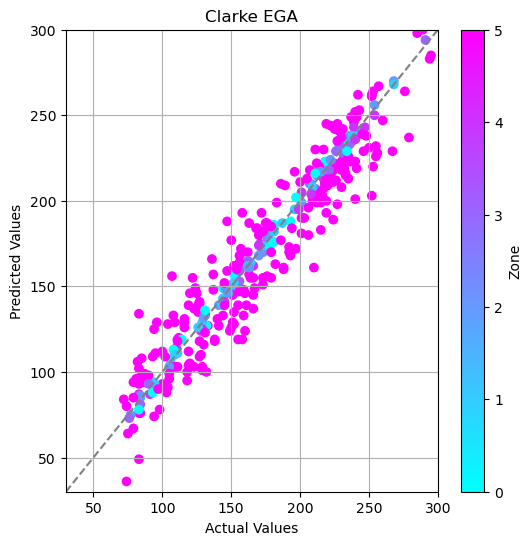

In [62]:
import matplotlib.pyplot as plt

# 生成示例数据，实际观测值和预测值
actual_values = true_value
predicted_values = pred_value

# 计算Clarke EGA图中的区域
def clarke_ega_region(actual, predicted):
    abs_diff = np.abs(predicted - actual)
    zones = np.zeros_like(abs_diff, dtype=int)
    zones[(abs_diff <= 1)] = 1
    zones[(abs_diff <= 2) & (abs_diff >1)] = 2
    zones[(abs_diff <= 3) & (abs_diff > 2)] = 3
    zones[(abs_diff <= 4) & (abs_diff > 3)] = 4
    zones[(abs_diff > 5)] = 5
    return zones

zones = clarke_ega_region(actual_values, predicted_values)

# 绘制Clarke EGA图
plt.figure(figsize=(6, 6))
plt.scatter(actual_values, predicted_values, c=zones, cmap='cool', marker='o')
plt.plot([30,300], [30,300], color='gray', linestyle='--')
plt.xlim(30,300)
plt.ylim(30,300)
plt.title("Clarke EGA")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

plt.grid()
plt.colorbar(label="Zone")

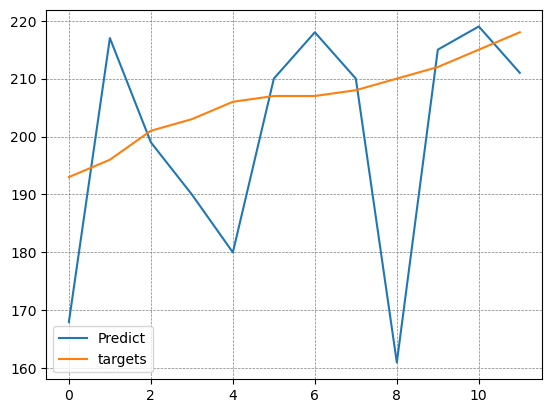

In [63]:
# 绘制predict 和 targets 的对比图
import matplotlib.pyplot as plt

plt.plot(pred_value[:12], label="Predict")    # 预测值
plt.plot(true_value[:12], label="targets")    # 真实值
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [179]:
# 想使用训练集的最后一个窗口预测训练集的下一个数据，再将窗口第一个数据弹出，将预测值插入窗口末尾组成一个新窗口。但是模型的输出是单个血糖值
# 缺了一些时间特征。要想实现真正的预测（有误差积累的预测）必须改变模型，使模型输出一个样本。
result = []
x = testX[0,0,:,:].unsqueeze(0).to(device)
print(x.shape)
for i in range(50):
    y = model(x)
    
    x = torch.cat((x[:,1:,:], y.unsqueeze(1)), dim=1)
    
    result.append(y.view(-1)[-1].cpu().detach().numpy())

torch.Size([1, 24, 7])


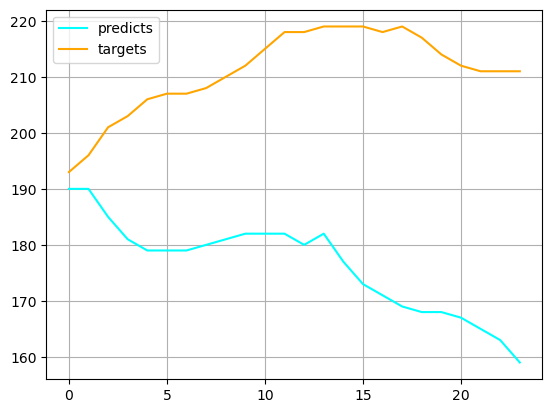

In [180]:
result = np.array(result)
pred_values = scaler.inverse_transform(result.reshape(-1, 1)).round()[:24]

true_values = testY[0,:50,-1].numpy().flatten()
true_values = scaler.inverse_transform(true_values.reshape(-1,1)).round()[:24]

plt.plot(pred_values,color='cyan',label='predicts')
plt.plot(true_values,color='orange', label='targets')
plt.legend()
plt.grid()
plt.show()